# Burst Fitting example using BurstFit class

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, gauss_norm, gauss_2d
from burstfit.io import BurstIO
import logging
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

## Get candidate cutout and preprocess

We will use `BurstData` class for this. It will crop the relevant time window. Dedisperse the data. Normalise the data to zero mean and unit standard deviation. Apply RFI masks (if any) and RFI filtering (if activated). 

In [3]:
#fil_file = '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil' # test data provided
#fil_file = '/data/dsa110/T1/corr02/2021_9_19_23_15_35/fil_210920aaai/210920aaai_98.fil' # our data (beam 98)
#fil_file = "/home/ubuntu/gechen/fake_data/test_1beams_10s.fil"
fil_file='/data/dsa110/T1/corr09/2021_8_31_21_33_56/fil_210901aabf/210901aabf_133.fil'
fil_name = '210901aabf_133'

In [4]:
# fil_211009aacy 
bd = BurstData(
    fp=fil_file,
    dm=60,
    tcand=0.5, # pulse starting time in s.
    width=32, # in time sample 
    snr=20.9, 
)

In [5]:
# We will mask channel numbers from 53 to 64 as they are 0. 
#bd.prepare_data(mask_chans=[(53, 64)])
#bd.prepare_data(mask_chans=[(0, 180), (900,1100)]) # ? 

bd.prepare_data(time_window=0.1) #time_window=0.2s, mask_chans=[],normalise=True

2021-10-28 22:42:08,295 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2021-10-28 22:42:08,402 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.1s.
2021-10-28 22:42:08,404 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2021-10-28 22:42:08,469 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (35.71415710449219, 21.263208398374175)


Using <class 'str'>:
/data/dsa110/T1/corr09/2021_8_31_21_33_56/fil_210901aabf/210901aabf_133.fil

In [6]:
# print(0.1/bd.tsamp)
# print(np.shape(bd.sgram))
# print(bd.mask)

In [7]:
#np.set_printoptions(threshold=np.inf)
# print(bd.data[200])
# print(bd.sgram)

In [8]:
# print(np.shape(bd.data))
# print(4./bd.tsamp/4)
# print(np.shape(bd.sgram))
# print(0.1/bd.tsamp)

Here is the burst

In [9]:
# plt.scatter(range(len(bd.data.mean(1))), bd.data.mean(1))
# plt.figure()
# plt.scatter(range(len(bd.sgram.mean(0))), bd.sgram.mean(0))

In [10]:
np.shape(bd.sgram.mask)

(1024, 380)

In [11]:
# plot_me(bd.data)
# plot_me(bd.sgram)

In [12]:
# For the plotter eror: 
# choose an available style from below:
# plt.style.available
# change burstfit/utils/plotter.py to use this style
# re-install: python setup.py install


In [13]:
#help(BurstData)

## Fitting using BurstFit

In `BurstFit`, the fitting procedure for each component is as follows: 
1. Fit the profile using `curve_fit` and a profile model
2. Find the spectra using profile fit parameters
3. Fit the spectra using `curve_fit` and spectra model 
4. Use the profile and spectra fit parameters as initial guess and fit the 2D spectrogram using `curve_fit` and spectrogram model 

Therefore, `BurstFit` requires three functions: profile function, spectra function and spectrogram function. It is assumed that spectrogram function will use profile and spectra functions to make the spectrogram.   

Use the `Model` class to make profile and spectra models. You can optionally give names of the input parameters. These parameter names are used by `BurstFit` to automatically set relevant fitting bounds and priors.  

In [14]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/ubuntu/proj/dsa110-shell/dsa110-T3/dsaT3/')
# import filplot_funcs as ff

sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

/home/ubuntu/gechen/software/filplot_funcs_gc.py:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes
2021-10-28 22:42:08,838 - _logit -dsaStore - INFO - {"mjd": 59515.94593562412, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2021-10-28T22:42:08.837912Z", "msg": "TODO: implement"}
2021-10-28 22:42:08,840 - _logit -dsaStore - INFO - {"mjd": 59515.94593564458, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2021-10-28T22:42:08.839682Z", "msg": "TODO: implement"}
2021-10-28 22:42:08,842 - _logit -dsaStore - INFO - {"mjd": 59515.94593567201, "proj":

Secrets not found. Cannot use datacite API


2021-10-28 22:42:09,434 - _logit -dsaStore - INFO - {"mjd": 59515.94594252579, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2021-10-28T22:42:09.434216Z", "msg": "TODO: implement"}
2021-10-28 22:42:09,436 - _logit -dsaStore - INFO - {"mjd": 59515.945942552324, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2021-10-28T22:42:09.436501Z", "msg": "TODO: implement"}
2021-10-28 22:42:09,439 - _logit -dsaStore - INFO - {"mjd": 59515.9459425821, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "c-tor", "level": "info", "time": "2021-10-28T22:42:09.439081Z", "msg": "DsaStore created"}
2021-10-28 22:42:09,442 - _logit -Conf - INFO - {"mjd": 59515.94594261595, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "Conf", "function": "_chec

In [15]:
data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=256, ndm=128) 

In [16]:
datadm_flip = np.flip(datadm, axis=0)

### fit for DM in the DM-time plot 

In [17]:
def extract_datadm(data_2d, t_min, t_max, dm_min, dm_max):
    x_low, x_high = (int(t_min*1e-3/bd.tsamp), int(t_max*1e-3/bd.tsamp)+1) 
    y_low, y_high = (np.where(dms > dm_min)[0][0], np.where(dms < dm_max)[0][-1]+1)
    region_x, region_y = np.meshgrid(range(x_low, x_high), range(y_low, y_high)) 
    region = np.dstack((region_x, region_y))
    
    #extent = 1e3*x_low * bd.tsamp, 1e3*x_high * bd.tsamp, dms[y_high], dms[y_low] 
    extent = 1e3*x_low * bd.tsamp, 1e3*x_high * bd.tsamp, dms[y_low], dms[y_high]
    xdata = (region_x, region_y)
    ydata = datadm[y_low: y_high, x_low: x_high]

    return xdata, ydata, extent 


t_min, t_max = 495, 505 # ms
dm_min, dm_max = 52, 62 
xdata, ydata, extent = extract_datadm(datadm_flip, t_min, t_max, dm_min, dm_max)


In [18]:
from scipy.optimize import curve_fit

# amplitude, x0, y0, sigma_x, sigma_y, offset, theta
initial_guess = (35, 0.5/bd.tsamp, bd.dm, 2, 2, 1, 0) 
popt_2d, pcov_2d = curve_fit(gauss_2d, xdata, ydata.ravel(), p0=initial_guess) 

datadm_amp, datadm_t0, datadm_dm, datadm_sigma_t0, datadm_sigma_dm, datadm_offset, datadm_theta = popt_2d
datadm_amp_err, datadm_t0_err, datadm_dm_err, datadm_sigma_t0_err, datadm_sigma_dm_err, datadm_offset_err, datadm_theta_err = [pcov_2d[i][i] for i in range(np.shape(pcov_2d)[0])]   


print('p0:', initial_guess)
print('\nResult:', popt_2d) 
print(pcov_2d)
print('DM: {:3.2f} \pm {:3.2f}'.format(datadm_dm, datadm_dm_err))

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


p0: (35, 1907.3486328124998, 60, 2, 2, 1, 0)

Result: [ 3.09065473e+02  1.91260337e+03 -1.05703307e+02 -8.90233744e+00
  1.36155731e+01  3.63089568e+01  1.91797555e-02]
[[inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]]
DM: -105.70 \pm inf


In [19]:
fit_2d_result = gauss_2d(xdata, popt_2d[0], popt_2d[1], popt_2d[2], popt_2d[3], popt_2d[4], popt_2d[5], popt_2d[6]).reshape(ydata.shape)

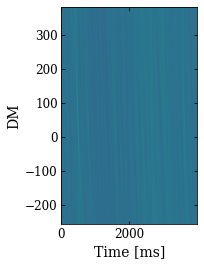

In [20]:
#%matplotlib notebook
%matplotlib inline

extent0 = 0, np.shape(datadm)[1]*bd.tsamp*1e3, dms[0], dms[-1]

fig0, ax0 = plt.subplots()
im0 = ax0.imshow(datadm_flip, extent=extent0, aspect=10)
ax0.set_xlabel('Time [ms]')
ax0.set_ylabel('DM')
fig0.savefig(fil_name+'_datadm.pdf') 


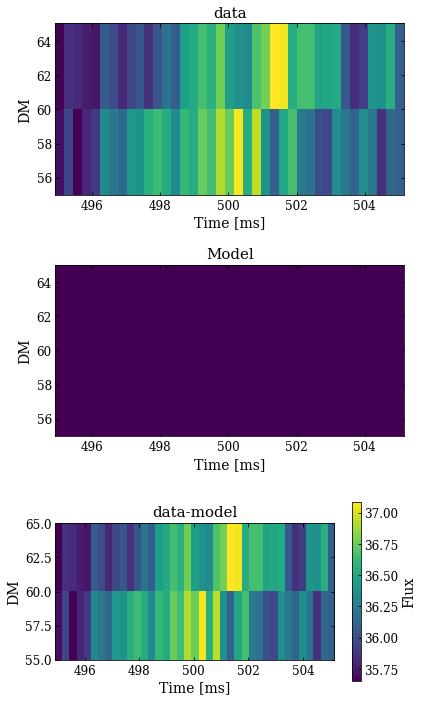

In [21]:
fig1, ax1 = plt.subplots(3, 1, figsize=(6,10))

im0 = ax1[0].imshow(ydata, extent=extent, aspect=0.5)
ax1[0].set_xlabel('Time [ms]')
ax1[0].set_ylabel('DM')
ax1[0].set_title('data')

#im_ratio = ydata.shape[1]/ydata.shape[0] 
#cbar = plt.colorbar(im1, fraction=0.046*im_ratio, pad=0.04)
cbar = plt.colorbar(im0)
cbar.set_label('Flux')


im1 = ax1[1].imshow(fit_2d_result, extent=extent, aspect=0.5)
ax1[1].set_xlabel('Time [ms]')
ax1[1].set_ylabel('DM')
ax1[1].set_title('Model')

im2 = ax1[2].imshow(ydata - fit_2d_result, extent=extent, aspect=0.5)
ax1[2].set_xlabel('Time [ms]')
ax1[2].set_ylabel('DM')
ax1[2].set_title('data-model')

fig1.tight_layout()
fig1.savefig(fil_name+'_datadm_fit.pdf')  

### check time series and spctrum

(256, 15258)
15258.789062499998


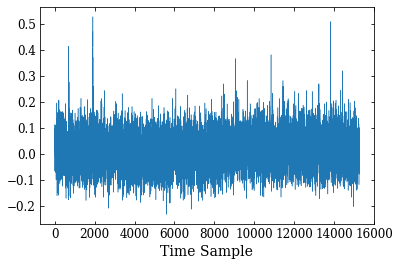

In [22]:
%matplotlib inline

plt.plot(range(len(data.mean(0))), data.mean(0))
plt.xlabel('Time Sample')

print(np.shape(data))
print(4./bd.tsamp) # /bd.width 4s per gulp, do not rebin by the pulse width 

Text(0.5, 0, 'Channels (binned)')

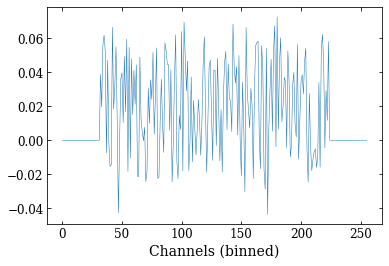

In [23]:
plt.plot(data.mean(1))
plt.xlabel('Channels (binned)')

In [24]:
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)

Now we create a spectrogram model using `SgramModel` class, with the above two models and a spectrogram function (`sgram_fn_vec`)

### Select data near the burst time for fittings

In [25]:
data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)]
sgram_mask = np.full(np.shape(data_burst), False)

In [26]:
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)

Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 

In [27]:
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, #bd.sgram not working 
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask 
)

In [28]:
# Some setting up before we do the fitting 
bf.validate()
bf.precalc()

The fit results are saved as a dictionary of dictionaries. The keys of the dictionary are component numbers. For each component, the dictionary consists of keys: `popt` and `perr`, representing the fitted parameters and their 1-sigma errors. 

So, let's fit one component:

### Profile Fit

2021-10-28 22:43:11,425 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-10-28 22:43:11,458 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-10-28 22:43:11,459 - initial_profilefit -burstfit.fit - INFO - S: 2694.4508890679067 +- 135.96106754187403
2021-10-28 22:43:11,460 - initial_profilefit -burstfit.fit - INFO - mu_t: 190.94133093080347 +- 0.6485522463353051
2021-10-28 22:43:11,461 - initial_profilefit -burstfit.fit - INFO - sigma_t: 11.130926249974047 +- 0.6485522548716238
2021-10-28 22:43:11,461 - initial_profilefit -burstfit.fit - INFO - tau: 1.0278464212366174 +- 0.0


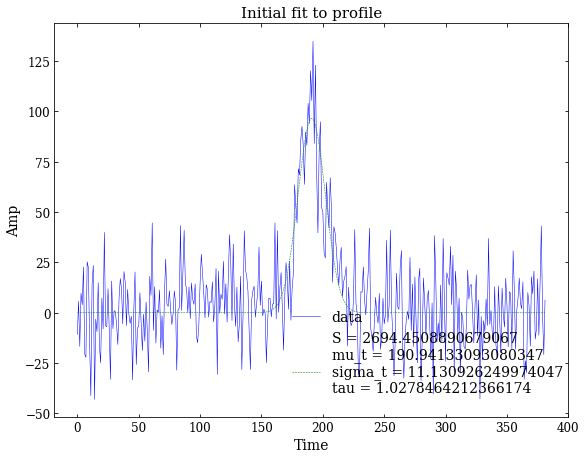

In [29]:
plot = True
profile_bounds=[]#((0, 0, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 
bf.initial_profilefit(plot=plot, bounds=profile_bounds)

### Spectra Fit

In [30]:
bf.make_spectra()

2021-10-28 22:43:11,699 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.


2021-10-28 22:43:11,709 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-10-28 22:43:11,716 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-28 22:43:11,717 - initial_spectrafit -burstfit.fit - INFO - mu_f: 96.95908392441487 +- 7.700319032246212
2021-10-28 22:43:11,718 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 65.40595406553948 +- 6.371634380635384


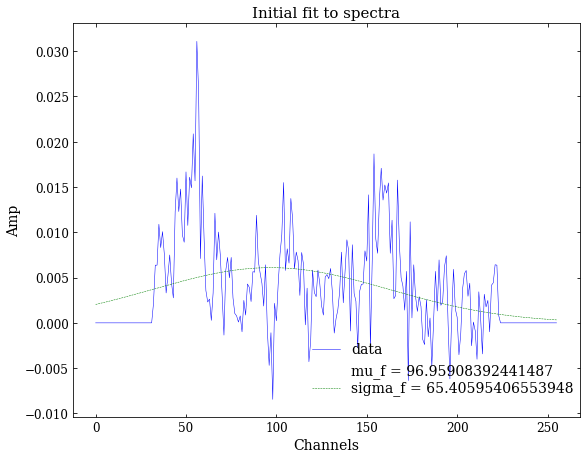

In [31]:
bf.initial_spectrafit(plot=plot)

Let's look at the profile and spectra fit parameters we just obtained 
(these were also printed in the logs above)

In [32]:
bf.profile_params

{1: {'popt': [2694.4508890679067,
   190.94133093080347,
   11.130926249974047,
   1.0278464212366174],
  'perr': array([135.96106754,   0.64855225,   0.64855225,   0.        ])}}

In [33]:
bf.spectra_params

{1: {'popt': [96.95908392441487, 65.40595406553948],
  'perr': array([7.70031903, 6.37163438])}}

Now the above parameters will be used as initial guess to do sgram fitting. 

### Spectrogram Fit

2021-10-28 22:43:11,934 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-10-28 22:43:11,935 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [96.95908392441487, 65.40595406553948, 2694.4508890679067, 190.94133093080347, 11.130926249974047, 1.0278464212366174, 60]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2021-10-28 22:43:12,209 - run_fit -burstfit.curvefit - WARNING - Fit errors are not finite. Retrying with p0+-(0.2*p0) bounds
2021-10-28 22:43:16,314 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-28 22:43:16,320 - sgram_fit -burstfit.fit - INFO - mu_f: 92.65884087752202 +- 3.6063341756095357
2021-10-28 22:43:16,321 - sgram_fit -burstfit.fit - INFO - sigma_f: 69.55929611281378 +- 4.1179765795008265
2021-10-28 22:43:16,321 - sgram_fit -burstfit.fit - INFO - S: 3121.259

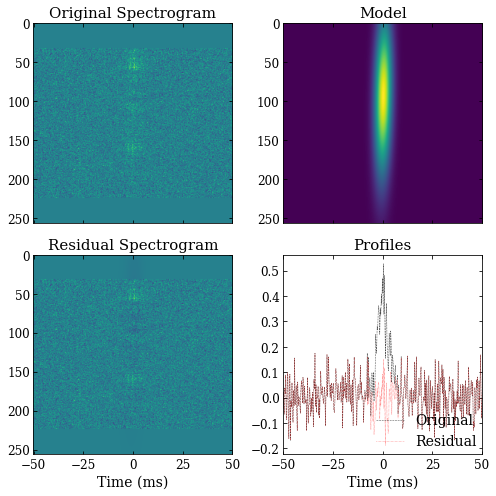

2021-10-28 22:43:16,888 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:16,889 - model -burstfit.fit - INFO - Found 1 components.


In [34]:
bf.sgram_fit(plot=plot)

We can see the reduced chi square value of our sgram_fit too

In [35]:
bf.calc_redchisq()

2021-10-28 22:43:16,899 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-28 22:43:16,900 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-10-28 22:43:16,901 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:16,902 - model -burstfit.fit - INFO - Found 1 components.
2021-10-28 22:43:16,909 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0037228655201376


1.0037228655201376

The fit parameters can be accessed using bf.sgram_params. It shows only one component as we only did one component fitting.

In [36]:
bf.sgram_params

{1: {'popt': [92.65884087752202,
   69.55929611281378,
   3121.2597469347184,
   193.41402137859038,
   11.484391717081893,
   1.0278464212366174,
   48.77614475306095],
  'perr': array([  3.60633418,   4.11797658, 164.46974755,   1.21260066,
           0.52959676,   0.        ,   5.12133924])}}

## fitcycle()

All the above steps have also been wrapped with fitcycle() 

2021-10-28 22:43:16,927 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-10-28 22:43:16,928 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-10-28 22:43:16,957 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-10-28 22:43:16,958 - initial_profilefit -burstfit.fit - INFO - S: 2694.4508890679067 +- 135.96106754187403
2021-10-28 22:43:16,959 - initial_profilefit -burstfit.fit - INFO - mu_t: 190.94133093080347 +- 0.6485522463353051
2021-10-28 22:43:16,960 - initial_profilefit -burstfit.fit - INFO - sigma_t: 11.130926249974047 +- 0.6485522548716238
2021-10-28 22:43:16,961 - initial_profilefit -burstfit.fit - INFO - tau: 1.0278464212366174 +- 0.0


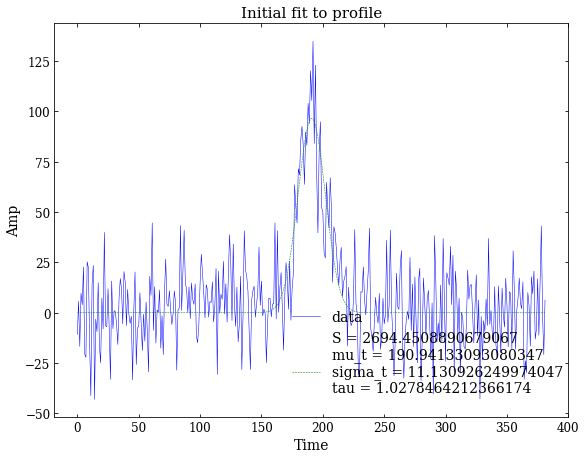

2021-10-28 22:43:17,161 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-10-28 22:43:17,162 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-10-28 22:43:17,166 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-28 22:43:17,167 - initial_spectrafit -burstfit.fit - INFO - mu_f: 96.95908392441487 +- 7.700319032246212
2021-10-28 22:43:17,168 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 65.40595406553948 +- 6.371634380635384


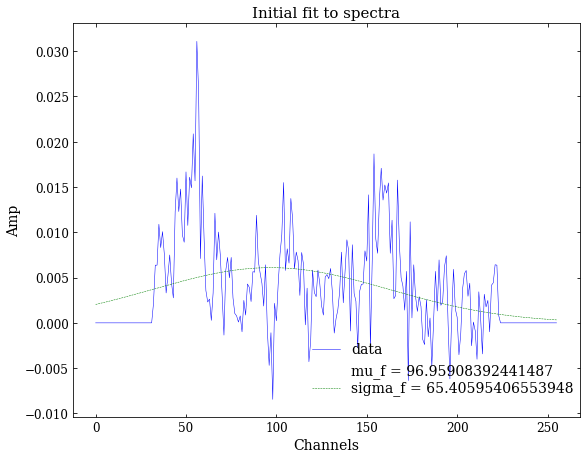

2021-10-28 22:43:17,350 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-10-28 22:43:17,351 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [96.95908392441487, 65.40595406553948, 2694.4508890679067, 190.94133093080347, 11.130926249974047, 1.0278464212366174, 60]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2021-10-28 22:43:17,588 - run_fit -burstfit.curvefit - WARNING - Fit errors are not finite. Retrying with p0+-(0.2*p0) bounds
2021-10-28 22:43:22,084 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-28 22:43:22,085 - sgram_fit -burstfit.fit - INFO - mu_f: 92.65884087752202 +- 3.6063341756095357
2021-10-28 22:43:22,086 - sgram_fit -burstfit.fit - INFO - sigma_f: 69.55929611281378 +- 4.1179765795008265
2021-10-28 22:43:22,087 - sgram_fit -burstfit.fit - INFO - S: 3121.259

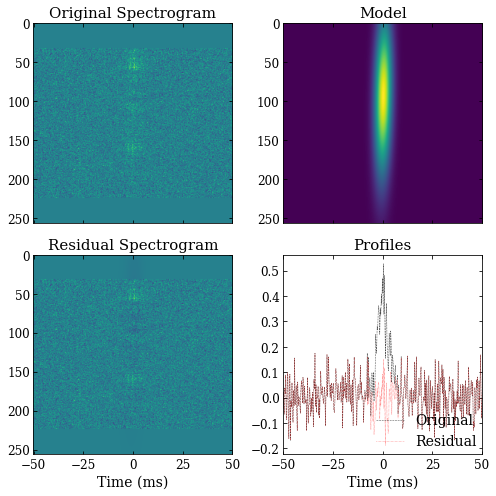

2021-10-28 22:43:22,769 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:22,770 - model -burstfit.fit - INFO - Found 1 components.
2021-10-28 22:43:22,779 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-28 22:43:22,780 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-10-28 22:43:22,781 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:22,782 - model -burstfit.fit - INFO - Found 1 components.
2021-10-28 22:43:22,793 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0037228655201376


In [37]:
bf.fitcycle(plot=True) #profile_bounds=[450, 550]

## fitall()

But `fitcycle()` only fits for one component. `BurstFit` can automatically fit for multiple components as well. For that we will use `fitall()`

Here it calls `fitcycle()` to fit for a component and then compares the ON-pulse residual with the OFF pulse regions (both left and right). If the distributions are similar then fitting is terminated. If the distributions aren't similar, then it tries to fit for another component. In the end, it will fit for all the components together. 

2021-10-28 22:43:22,799 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-28 22:43:22,800 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-28 22:43:22,814 - tests -root - INFO - P values: T-test (0.59800), Kruskal (0.63805), KS (0.99664), F-test (0.32334)
2021-10-28 22:43:22,815 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2021-10-28 22:43:22,840 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00000)
2021-10-28 22:43:22,841 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2021-10-28 22:43:22,865 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00000)
2021-10-28 22:43:22,866 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-10-28 22:43:22,867 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-10-28 22:43:22,895 - initial_profilefi

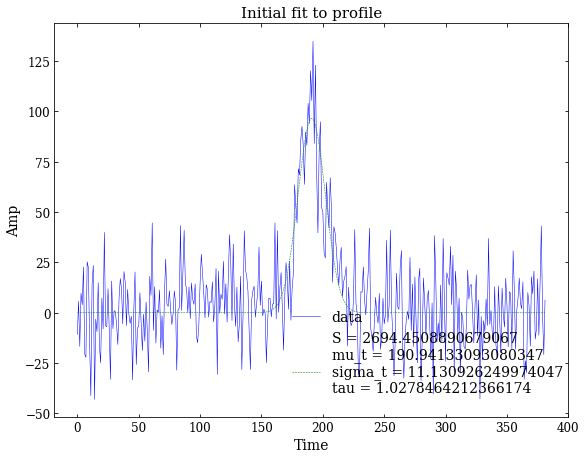

2021-10-28 22:43:23,134 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-10-28 22:43:23,135 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-10-28 22:43:23,140 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-28 22:43:23,141 - initial_spectrafit -burstfit.fit - INFO - mu_f: 96.95908392441487 +- 7.700319032246212
2021-10-28 22:43:23,141 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 65.40595406553948 +- 6.371634380635384


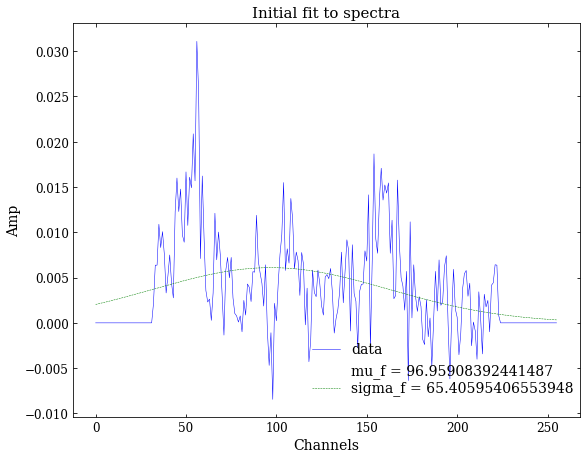

2021-10-28 22:43:23,321 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-10-28 22:43:23,322 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [96.95908392441487, 65.40595406553948, 2694.4508890679067, 190.94133093080347, 11.130926249974047, 1.0278464212366174, 60]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2021-10-28 22:43:23,569 - run_fit -burstfit.curvefit - WARNING - Fit errors are not finite. Retrying with p0+-(0.2*p0) bounds
2021-10-28 22:43:28,602 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-28 22:43:28,605 - sgram_fit -burstfit.fit - INFO - mu_f: 92.65884087752202 +- 3.6063341756095357
2021-10-28 22:43:28,605 - sgram_fit -burstfit.fit - INFO - sigma_f: 69.55929611281378 +- 4.1179765795008265
2021-10-28 22:43:28,606 - sgram_fit -burstfit.fit - INFO - S: 3121.259

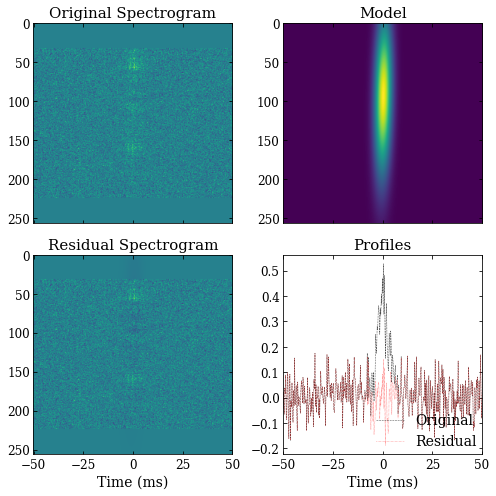

2021-10-28 22:43:29,161 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:29,163 - model -burstfit.fit - INFO - Found 1 components.
2021-10-28 22:43:29,168 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-28 22:43:29,169 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-10-28 22:43:29,170 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:29,171 - model -burstfit.fit - INFO - Found 1 components.
2021-10-28 22:43:29,182 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0037228655201376
2021-10-28 22:43:29,182 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-28 22:43:29,183 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-28 22:43:29,198 - tests -root - INFO - P values: T-test (0.59800), Kruskal (0.63805), KS (0.99664), F-test (0.32334)
2021-10-28 22:43:29,198 - run

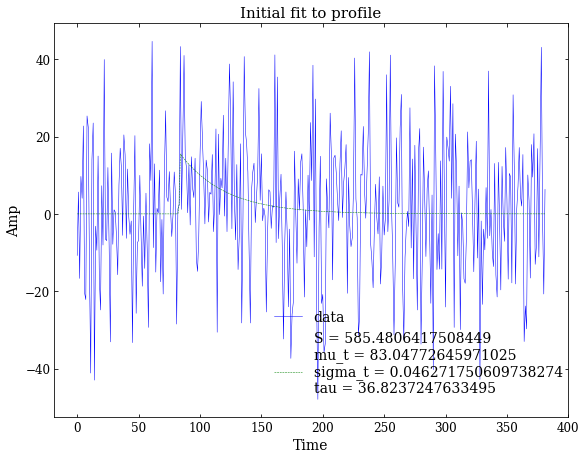

2021-10-28 22:43:29,469 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-10-28 22:43:29,472 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 2
2021-10-28 22:43:29,479 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-10-28 22:43:29,479 - initial_spectrafit -burstfit.fit - INFO - mu_f: 185.8740598601282 +- 6.580715564039072
2021-10-28 22:43:29,480 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 25.30843022049895 +- 5.381143739059832


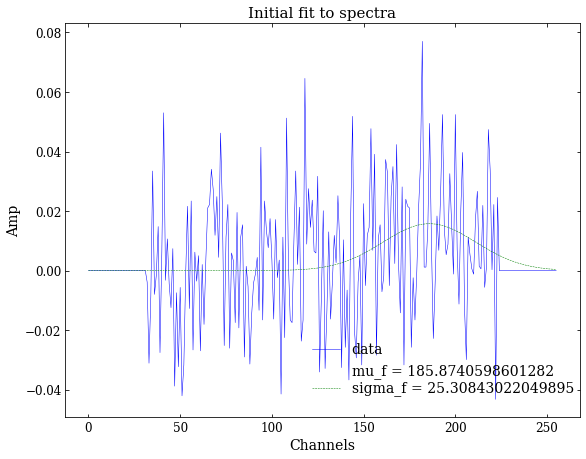

2021-10-28 22:43:29,664 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 2
2021-10-28 22:43:29,665 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [185.8740598601282, 25.30843022049895, 585.4806417508449, 83.04772645971025, 0.046271750609738274, 36.8237247633495, 60]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/burstfit-0.1.1-py3.6.egg/burstfit/utils/functions.py:167: RuntimeWarning: overflow encountered in exp
  B = np.exp((1 / 2) * (sigma / tau) ** 2)
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2021-10-28 22:43:30,384 - run_fit -burstfit.curvefit - WARNING - Fit errors are not finite. Retrying with p0+-(0.2*p0) bounds
2021-10-28 22:43:31,540 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-10-28 22:43:31,544 - sgram_fit -burstfit.fit - INFO - mu_f: 183.2043457223

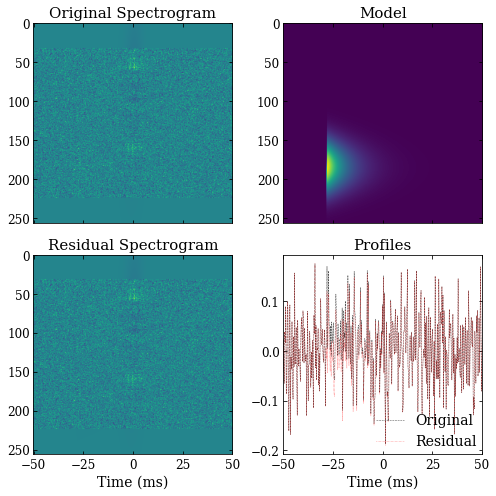

2021-10-28 22:43:32,094 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:32,095 - model -burstfit.fit - INFO - Found 2 components.
2021-10-28 22:43:32,111 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-28 22:43:32,112 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-10-28 22:43:32,113 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:32,114 - model -burstfit.fit - INFO - Found 2 components.
2021-10-28 22:43:32,126 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0831649669434882
2021-10-28 22:43:32,127 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-28 22:43:32,127 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-28 22:43:32,142 - tests -root - INFO - P values: T-test (0.59800), Kruskal (0.63805), KS (0.99664), F-test (0.32334)
2021-10-28 22:43:32,143 - run

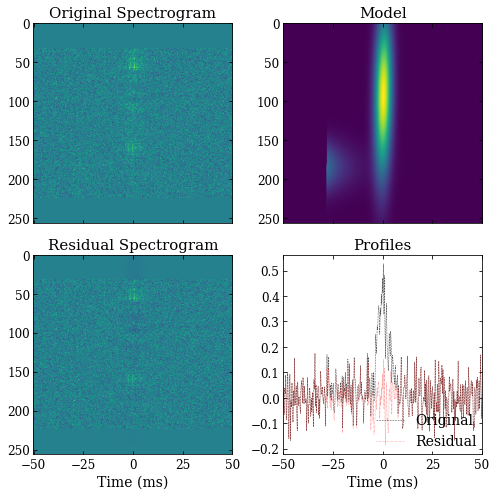

2021-10-28 22:43:36,730 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:36,731 - model -burstfit.fit - INFO - Found 2 components.
2021-10-28 22:43:36,738 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-10-28 22:43:36,739 - get_off_pulse_region -burstfit.fit - INFO - Using sgram all-component-fit parameters.
2021-10-28 22:43:36,741 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:36,741 - model -burstfit.fit - INFO - Found 2 components.
2021-10-28 22:43:36,752 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0428969692184915
2021-10-28 22:43:36,753 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-10-28 22:43:36,753 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-10-28 22:43:36,763 - tests -root - INFO - P values: T-test (0.59800), Kruskal (0.63805), KS (0.99664), F-test (0.32334)
2021-10-28 22:4

In [38]:
bf.fitall(plot=True)

The logging above shows the results of the statistical tests performed to compare the ON pulse residual with OFF pulse regions. Both the Left and Right off pulse regions were found to be statistically similar to ON pulse residual, and therefore the fitting was terminated. 

Again, the parameters can be accessed using `sgram_params`. The final parameters are saved in "all" key. This is useful in case of multiple components. In that case, individual component number will show the fit results for inidividual component, while "all" will give the result of fitting all the components together. In this case, we just had one component, so `fit_all_components` wasn't used, and therefore key "1" and "all" have same parameters. 

In [39]:
bf.sgram_params['all']

{1: {'popt': [91.54670454519068,
   68.48656534140585,
   3059.658166251428,
   193.17484533722586,
   11.382602209686548,
   1.0278584491448437,
   50.04998963043583],
  'perr': array([3.61389066e+00, 4.13361526e+00, 1.66062168e+02, 1.21378855e+00,
         5.31025001e-01, 1.27694326e-12, 5.20186920e+00])},
 2: {'popt': [183.46448406614581,
   21.36440521767357,
   412.2559694127607,
   86.75007513750424,
   0.029712835465034722,
   28.74416139216495,
   50.80904614351521],
  'perr': array([  5.15476551,   5.14140979, 114.64698807,   5.19076101,
           0.28573012,  10.30575033,  12.67756797])}}

## Plotting Results 

We can also plot the model, sgram and residuals

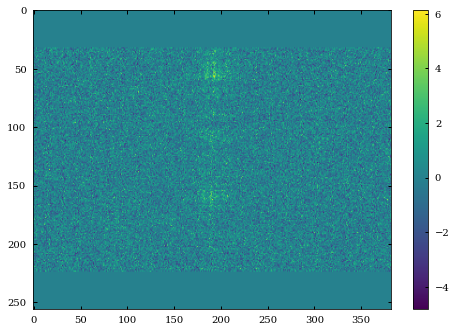

In [40]:
plot_me(bf.sgram)

2021-10-28 22:43:37,079 - model -burstfit.fit - INFO - Making model.
2021-10-28 22:43:37,080 - model -burstfit.fit - INFO - Found 2 components.


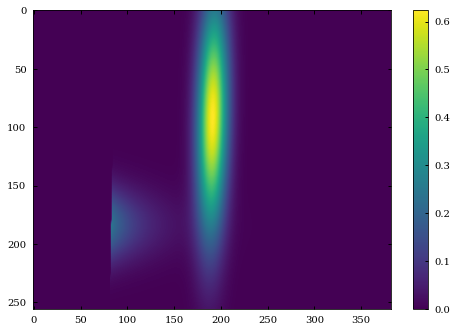

In [41]:
plot_me(bf.model)

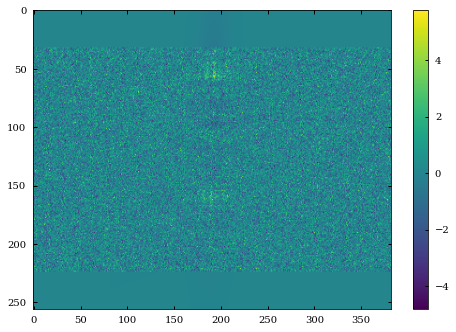

In [42]:
plot_me(bf.residual)

There are two ways of visualising plotting results using multi-panel plots. Using `plot_2d_fit` and `plot_fit_results`

In [43]:
from burstfit.utils.plotter import plot_2d_fit, plot_fit_results

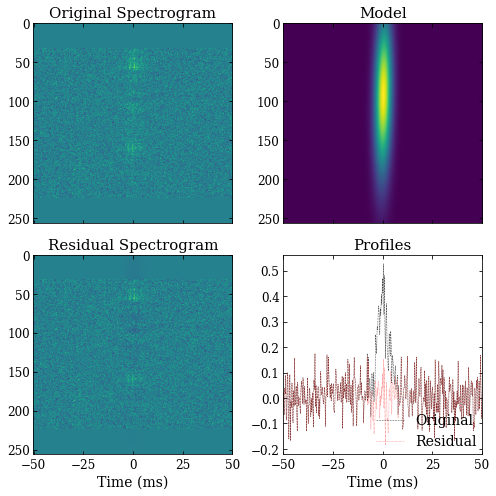

In [44]:
plot_2d_fit(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
            bf.tsamp, show=True, save=False)

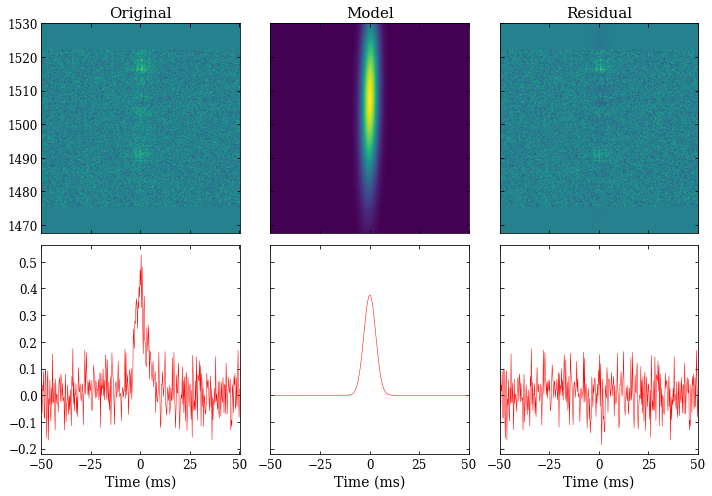

In [45]:
plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
                 bf.tsamp, bf.fch1, bf.foff, show=True, save=False)

Now, to save the fitting results we can use `BurstIO` class. See this notebook.  